In [1]:
import sys
import os
sys.path.append('..')
from lib.path import get_training_data_dir, get_predicted_labeled_water_path, get_displaceable_water_path, get_non_displaceable_water_path
from lib.pdb import filter_atoms_and_create_new_pdb
from data_loader.SingleDataLoader import SingleDataLoader
from data_loader.DoubleDataLoader import DoubleDataLoader
from models.LeNet import LeNet
from models.ResNet import ResNet, ResNet1
from lib.helper import get_latest_checkpoint
from tensorflow.keras.losses import BinaryCrossentropy
from custom_losses.dice import dice_loss, dice_coefficient
from tensorflow.keras.metrics import Recall, Precision, Accuracy, SpecificityAtSensitivity, AUC, F1Score
import numpy as np

2024-06-03 09:33:35.106793: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 09:33:35.109269: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-03 09:33:35.141291: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 09:33:35.141311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 09:33:35.142490: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
DATA_TYPE1 = 'gr'
# DATA_TYPE2 = 'Protein'
DATA_VOXEL_NUM = 10
CLASSIFYING_RULE = 'WaterClassifyingRuleSurface'
LIGAND_POCKET_DEFINER = 'LigandPocketDefinerOriginal'
LIGAND_VOXEL_NUM = 8
MODEL_NAME = 'ResNet1'
TRAINER_NAME = 'aug_train_90'
training_data_dir1 = get_training_data_dir(DATA_TYPE1, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)
# training_data_dir2 = get_training_data_dir(DATA_TYPE2, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)

data_dir = '../../data'
test_list = os.path.join(data_dir, 'test_list')
data_loader = SingleDataLoader(training_data_dir1)
# data_loader = DoubleDataLoader(training_data_dir1, training_data_dir2)
test_data, test_data_label = data_loader.load_data(test_list)

29
15
28
19
17
1
26
20
23
11
11
27
28
31
8
27
27
28
24
27
6
5
25
23
22
30
30
30
27
5
6
4
6
17
27
21
11
25
27
23
15
26
23
26
25
20
23
26
33
31
31
31
28
20
24
26
21
22
26
23
14
12
17
8
25
29
22
24
10
23
31
18
19
26
6
8
24
23
9
22
27
12
14
11
15
23
14
17
23
12
8
5
28
12
11
8
17
30
31
28
23
24
27
23
23
26
14
9
11
29
27
30
24
13
17
24
11
17
27
23
25
26
Error processing 2bys: No data found for 2bys
25
26
5
12
25
24
28
15
15
16
20
11
27
25
25
25
26
23
Error processing 2jke: No data found for 2jke
Error processing 2jkp: No data found for 2jkp
25
24
12
20
13
17
22
19
20
26
24
22
23
25
23
23
21
18
24
20
23
22
22
23
30
24
26
14
9
22
24
21
20
3
13
22
31
1
8
6
9
6
7
6
9
14
12
8
26
8
16
7
14
Error processing 2xp7: No data found for 2xp7
12
16
22
18
10
10
13
Error processing 2zq0: No data found for 2zq0
24
20
21
12
6
43
16
13
22
19
27
24
22
25
6
8
5
7
18
26
25
25
7
8
14
24
15
8
7
11
Error processing 3i4b: No data found for 3i4b
21
22
24
20
19
20
21
22
10
26
24
11
17
13
9
9
24
23
24
22
21
15
16
19
22


2024-06-03 09:33:58.779425: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
input_shape = (DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, test_data.shape[-1])
n_base = 8
learning_rate = 1e-4
metrics = ['accuracy', dice_coefficient, Recall(), Precision()]
BN = True

In [8]:
checkpoint_dir = f'../checkpoints/{DATA_TYPE1}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
# checkpoint_dir = f'../checkpoints/{DATA_TYPE1}_{DATA_TYPE2}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
model = ResNet1(n_base, input_shape, learning_rate, BinaryCrossentropy(), metrics, BN=BN)
model.load_weights(latest_checkpoint)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 21, 21, 21, 1)]      0         []                            
                                                                                                  
 conv3d_9 (Conv3D)           (None, 21, 21, 21, 8)        224       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_9 (Bat  (None, 21, 21, 21, 8)        32        ['conv3d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_7 (Activation)   (None, 21, 21, 21, 8)        0         ['batch_normalization_9[

In [9]:
prediction = model.predict(test_data)
prediction_values = prediction.reshape(prediction.shape[0])
predicted_label = prediction.round()


423/423 [==============================] - 2s 5ms/step


In [10]:
recall = Recall()
recall.update_state(test_data_label, predicted_label)
recall_value = recall.result().numpy()

precision = Precision()
precision.update_state(test_data_label, predicted_label)
precision_value = precision.result().numpy()

accuracy = Accuracy()
accuracy.update_state(test_data_label, predicted_label)
accuracy_value = accuracy.result().numpy()

specificity = SpecificityAtSensitivity(recall_value)
specificity.update_state(test_data_label, predicted_label)
specificity_value = specificity.result().numpy()

auc = AUC()
auc.update_state(test_data_label, prediction_values)
auc_value = auc.result().numpy()


In [11]:
print({"recall": recall_value, "precision": precision_value, "accuracy": accuracy_value, "specificity": specificity_value, "dice_coefficient": dice_coefficient(test_data_label, predicted_label).numpy(), "auc": auc_value})

{'recall': 0.6987024, 'precision': 0.74786323, 'accuracy': 0.7213175, 'specificity': 0.7457288, 'dice_coefficient': 0.72246796, 'auc': 0.7945277}


In [12]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(test_data_label, prediction_values)

In [13]:
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold_youden = thresholds[optimal_idx]
optimal_threshold_youden

0.46461126

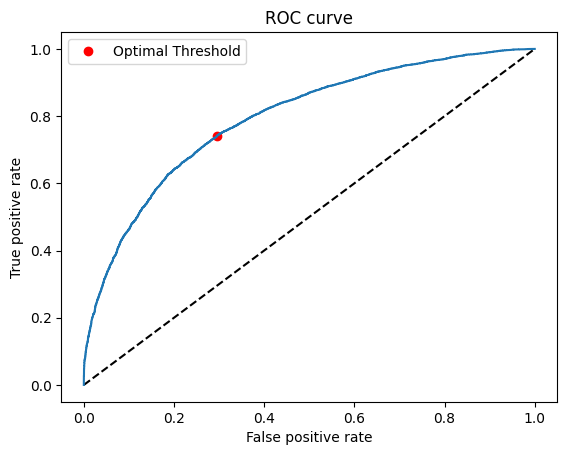

In [14]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label='Optimal Threshold')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [15]:
def custom_threshold(prediction, threshold):
    return (prediction > threshold).astype(int)
optimal_predicted_label = custom_threshold(prediction_values, optimal_threshold_youden)

In [16]:
recall = Recall()
recall.update_state(test_data_label, optimal_predicted_label)
optimal_recall_value = recall.result().numpy()

precision = Precision()
precision.update_state(test_data_label, optimal_predicted_label)
optimal_precision_value = precision.result().numpy()

accuracy = Accuracy()
accuracy.update_state(test_data_label, optimal_predicted_label)
optimal_accuracy_value = accuracy.result().numpy()

specificity = SpecificityAtSensitivity(optimal_recall_value)
specificity.update_state(test_data_label, optimal_predicted_label)
optimal_specificity_value = specificity.result().numpy()

auc = AUC()
auc.update_state(test_data_label, prediction_values)
auc_value = auc.result().numpy()


In [17]:
print({"recall": optimal_recall_value, "precision": optimal_precision_value, "accuracy": optimal_accuracy_value, "specificity": optimal_specificity_value, "dice_coefficient": dice_coefficient(test_data_label, optimal_predicted_label).numpy(), "auc": auc_value})

{'recall': 0.74205047, 'precision': 0.73059106, 'accuracy': 0.72405624, 'specificity': 0.7046329, 'dice_coefficient': 0.7362948, 'auc': 0.7945277}
